In [22]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('data/dados_finais.csv')
df.head()

,Carimbo_de_data_hora,Temperatura,Umidade_do_Ar,Umidade_do_Solo,Minutos_Decorridos,ID_Ciclo,Minutos_Decorridos_No_Ciclo
0,2025-06-18 01:10:01,22.0,83.6,86.1,0.00,0,0.00
1,2025-06-18 01:40:02,22.0,83.7,87.0,30.02,0,30.02
2,2025-06-18 02:10:02,20.6,89.9,88.4,60.02,0,60.02
3,2025-06-18 02:40:03,20.3,90.8,87.8,90.03,0,90.03
4,2025-06-18 03:10:04,20.3,90.4,88.4,120.05,0,120.05


In [24]:
print("\n Informações Iniciais do DataFrame")
print(df.head())
print(df.info())
print("\nContagem de NaNs (antes da conversão):")
print(df.isnull().sum())



 Informações Iniciais do DataFrame
  Carimbo_de_data_hora  Temperatura  Umidade_do_Ar  Umidade_do_Solo  \
0  2025-06-18 01:10:01         22.0           83.6             86.1   
1  2025-06-18 01:40:02         22.0           83.7             87.0   
2  2025-06-18 02:10:02         20.6           89.9             88.4   
3  2025-06-18 02:40:03         20.3           90.8             87.8   
4  2025-06-18 03:10:04         20.3           90.4             88.4   

   Minutos_Decorridos  ID_Ciclo  Minutos_Decorridos_No_Ciclo  
0                0.00         0                         0.00  
1               30.02         0                        30.02  
2               60.02         0                        60.02  
3               90.03         0                        90.03  
4              120.05         0                       120.05  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype

In [25]:
# definir colunas para float
numeric_float_cols = ['Temperatura', 'Umidade_do_Ar', 'Umidade_do_Solo']

# definir as colunas que devem ser inteiras
numeric_int_cols = ['Minutos_Decorridos', 'Minutos_Decorridos_No_Ciclo', 'ID_Ciclo']

# converter colunas float
for col in numeric_float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


for col in numeric_int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(0) 
    df[col] = df[col].astype(np.int64) 

# converter Carimbo_de_data_hora para datetime
df['Carimbo_de_data_hora'] = pd.to_datetime(df['Carimbo_de_data_hora'], errors='coerce')

print("\nInformações do DataFrame")
print(df.info())
print("\nContagem de NaNs (após a conversão):")
print(df.isnull().sum())


Informações do DataFrame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 921 entries, 0 to 920
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Carimbo_de_data_hora         921 non-null    datetime64[ns]
 1   Temperatura                  921 non-null    float64       
 2   Umidade_do_Ar                921 non-null    float64       
 3   Umidade_do_Solo              921 non-null    float64       
 4   Minutos_Decorridos           921 non-null    int64         
 5   ID_Ciclo                     921 non-null    int64         
 6   Minutos_Decorridos_No_Ciclo  921 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 50.5 KB
None

Contagem de NaNs (após a conversão):
Carimbo_de_data_hora           0
Temperatura                    0
Umidade_do_Ar                  0
Umidade_do_Solo                0
Minutos_Decorridos             0
ID_Cicl


DataFrame após remover NaNs: 921 linhas restantes.

 Verificando o tamanho de cada ciclo após a limpeza
ID_Ciclo
0    158
1     90
2     57
3    195
4    421
dtype: int64

Número de ciclos com menos de 2 pontos de dados: 0


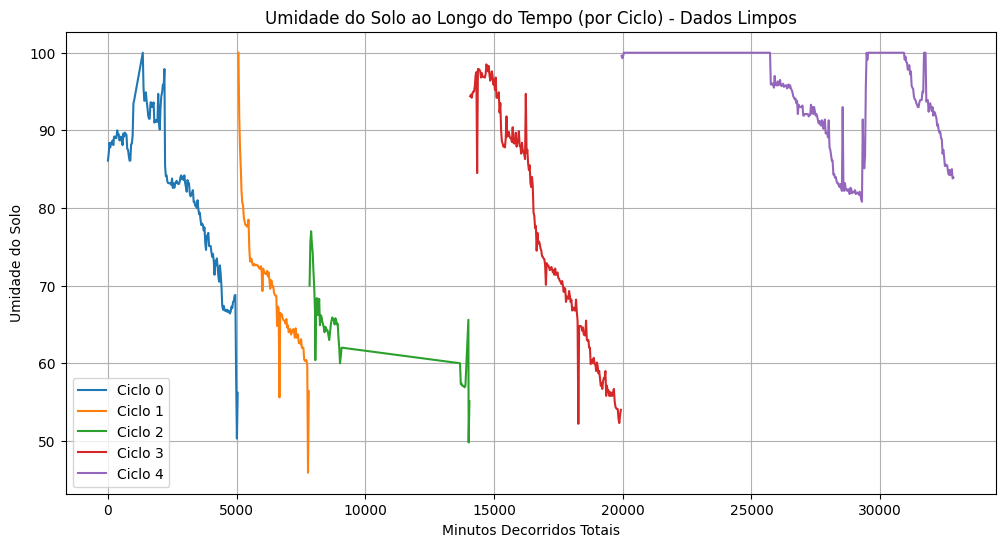

In [26]:
# tratamento de NaNs
df_cleaned = df.dropna(subset=numeric_float_cols + numeric_int_cols).copy() 
print(f"\nDataFrame após remover NaNs: {len(df_cleaned)} linhas restantes.")

# garantir que os dados estejam ordenados por ciclo e tempo
df_cleaned = df_cleaned.sort_values(by=['ID_Ciclo', 'Minutos_Decorridos_No_Ciclo'])

print("\n Verificando o tamanho de cada ciclo após a limpeza")
cycle_counts = df_cleaned.groupby('ID_Ciclo').size()
print(cycle_counts)
ar_order = 1 
num_short_cycles = sum(cycle_counts <= ar_order)
print(f"\nNúmero de ciclos com menos de {ar_order + 1} pontos de dados: {num_short_cycles}")

# plotar para visualizar os ciclos e os saltos (usando Minutos_Decorridos para o eixo x)
plt.figure(figsize=(12, 6))
for cycle_id in df_cleaned['ID_Ciclo'].unique():
    cycle_data = df_cleaned[df_cleaned['ID_Ciclo'] == cycle_id]
    plt.plot(cycle_data['Minutos_Decorridos'], cycle_data['Umidade_do_Solo'], label=f'Ciclo {cycle_id}')
plt.title('Umidade do Solo ao Longo do Tempo (por Ciclo) - Dados Limpos')
plt.xlabel('Minutos Decorridos Totais')
plt.ylabel('Umidade do Solo')
plt.legend()
plt.grid(True)
plt.show()


Iniciando treinamento dos modelos ARX para cada ciclo

 Treinando modelo para o Ciclo 0 
                            AutoReg Model Results                             
Dep. Variable:        Umidade_do_Solo   No. Observations:                  158
Model:                   AutoReg-X(1)   Log Likelihood                -323.862
Method:               Conditional MLE   S.D. of innovations              1.904
Date:                Fri, 18 Jul 2025   AIC                            657.724
Time:                        18:18:34   BIC                            673.006
Sample:                             1   HQIC                           663.931
                                  158                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.5148      6.710     -0.524      0.600     -16.666       9.637
Umidade_do_Solo.L

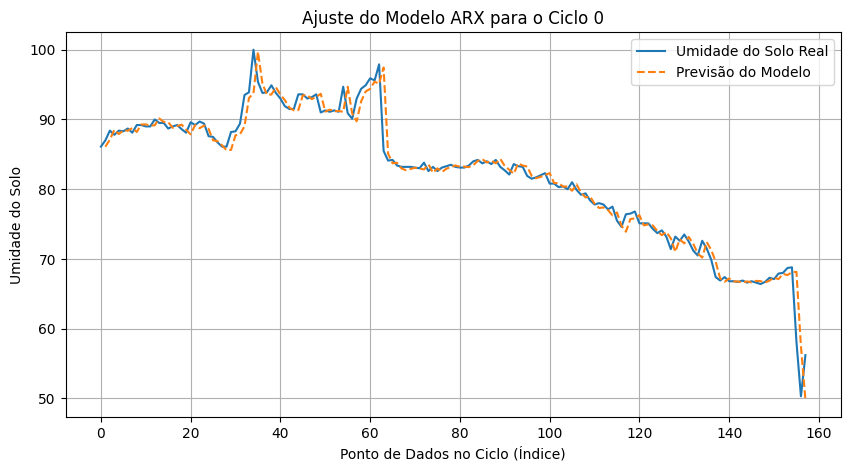


 Treinando modelo para o Ciclo 1 
                            AutoReg Model Results                             
Dep. Variable:        Umidade_do_Solo   No. Observations:                   90
Model:                   AutoReg-X(1)   Log Likelihood                -208.364
Method:               Conditional MLE   S.D. of innovations              2.515
Date:                Fri, 18 Jul 2025   AIC                            426.729
Time:                        18:18:34   BIC                            439.172
Sample:                             1   HQIC                           431.744
                                   90                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 44.6691     15.282      2.923      0.003      14.716      74.622
Umidade_do_Solo.L1     0.8277      0.043     19.188      0.000       0.7

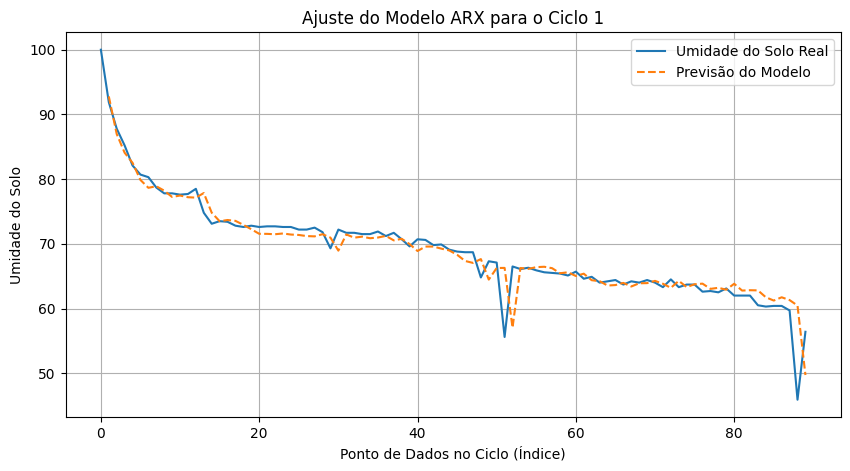


 Treinando modelo para o Ciclo 2 
                            AutoReg Model Results                             
Dep. Variable:        Umidade_do_Solo   No. Observations:                   57
Model:                   AutoReg-X(1)   Log Likelihood                -137.769
Method:               Conditional MLE   S.D. of innovations              2.833
Date:                Fri, 18 Jul 2025   AIC                            285.539
Time:                        18:18:34   BIC                            295.665
Sample:                             1   HQIC                           289.465
                                   57                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.7737     31.579      0.120      0.905     -58.119      65.667
Umidade_do_Solo.L1     0.7575      0.103      7.384      0.000       0.5

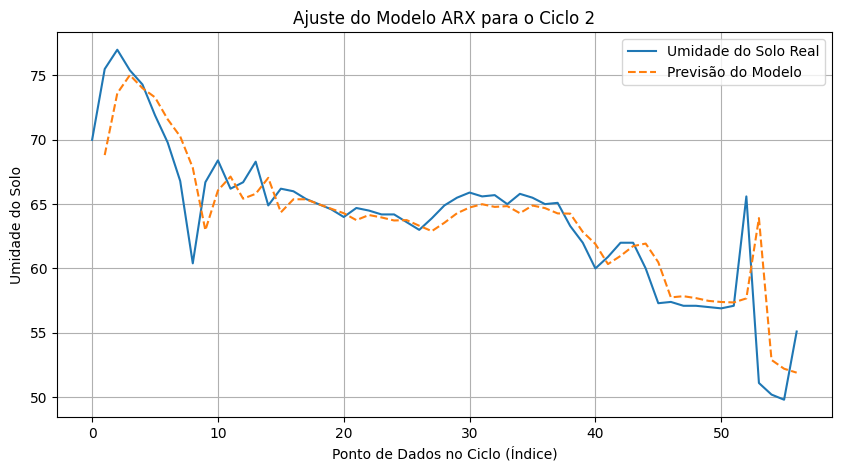


 Treinando modelo para o Ciclo 3 
                            AutoReg Model Results                             
Dep. Variable:        Umidade_do_Solo   No. Observations:                  195
Model:                   AutoReg-X(1)   Log Likelihood                -434.612
Method:               Conditional MLE   S.D. of innovations              2.274
Date:                Fri, 18 Jul 2025   AIC                            879.223
Time:                        18:18:34   BIC                            895.562
Sample:                             1   HQIC                           885.839
                                  195                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6021      8.639      0.301      0.763     -14.330      19.534
Umidade_do_Solo.L1     0.9874      0.011     86.157      0.000       0.9

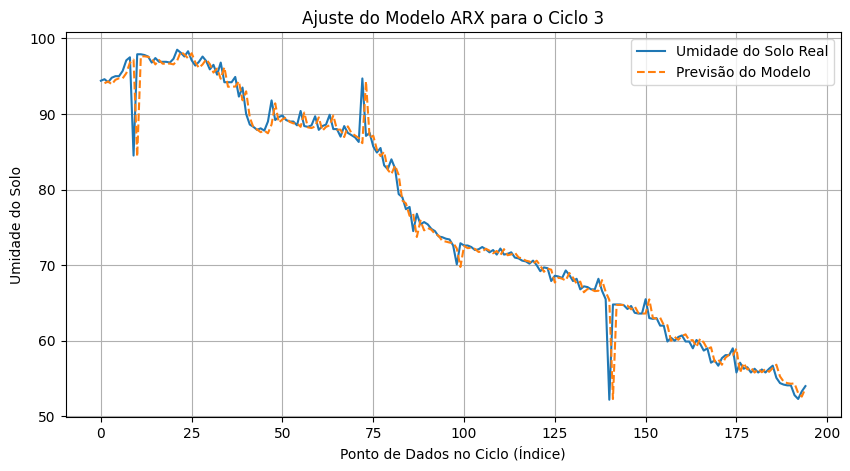


 Treinando modelo para o Ciclo 4 
                            AutoReg Model Results                             
Dep. Variable:        Umidade_do_Solo   No. Observations:                  421
Model:                   AutoReg-X(1)   Log Likelihood                -679.809
Method:               Conditional MLE   S.D. of innovations              1.221
Date:                Fri, 18 Jul 2025   AIC                           1369.618
Time:                        18:18:35   BIC                           1389.819
Sample:                             1   HQIC                          1377.602
                                  421                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.4767      2.439      0.605      0.545      -3.303       6.257
Umidade_do_Solo.L1     0.9803      0.010     94.627      0.000       0.9

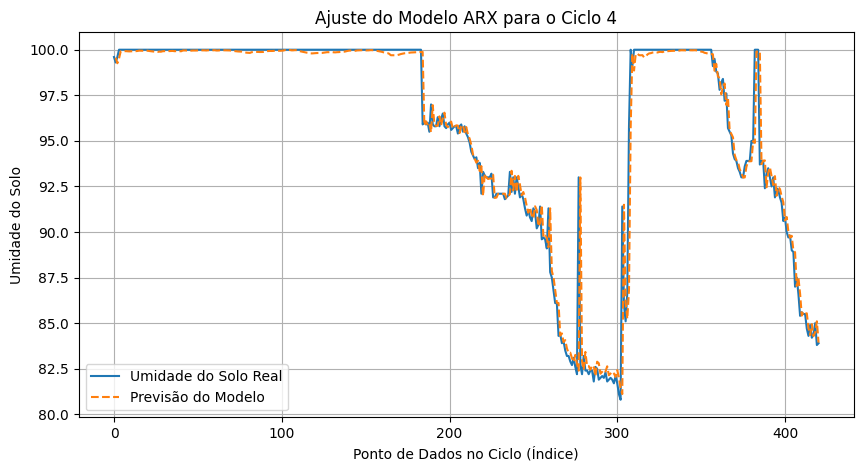


 Resumo dos Modelos e Métricas 
Ciclo 0: RMSE = 1.90
Ciclo 1: RMSE = 2.51
Ciclo 2: RMSE = 2.83
Ciclo 3: RMSE = 2.27
Ciclo 4: RMSE = 1.22


In [27]:
# treinamento de modelos individuais por ciclo

ciclo_models = {}
ciclo_metrics = {}

print("\nIniciando treinamento dos modelos ARX para cada ciclo")

for cycle_id in df_cleaned['ID_Ciclo'].unique():
    print(f"\n Treinando modelo para o Ciclo {cycle_id} ")
    
    cycle_data = df_cleaned[df_cleaned['ID_Ciclo'] == cycle_id].copy()
    
    y = cycle_data['Umidade_do_Solo']
    X = cycle_data[['Temperatura', 'Umidade_do_Ar']]
    
    y = y.reset_index(drop=True)
    X = X.reset_index(drop=True)

    if len(y) <= ar_order:
        print(f"Dados insuficientes ({len(y)} pontos) para o Ciclo {cycle_id} com AR order {ar_order}. Pulando.")
        continue

    try:
        model = AutoReg(y, lags=ar_order, exog=X)
        model_fit = model.fit()
        
        ciclo_models[cycle_id] = model_fit
        
        print(model_fit.summary())
        
        y_true_for_rmse = y.iloc[ar_order:]
        predictions = model_fit.fittedvalues
        
        if predictions.isnull().any():
            print(f"AVISO: Previsões para o Ciclo {cycle_id} contêm NaNs. RMSE pode ser inválido.")
            rmse = np.nan 
        else:
            rmse = np.sqrt(mean_squared_error(y_true_for_rmse, predictions))
        
        ciclo_metrics[cycle_id] = {'RMSE': rmse}
        
        print(f"RMSE para o Ciclo {cycle_id}: {rmse:.2f}")

        plt.figure(figsize=(10, 5))
        plt.plot(y.index, y, label='Umidade do Solo Real')
        plt.plot(predictions.index, predictions, label='Previsão do Modelo', linestyle='--')
        plt.title(f'Ajuste do Modelo ARX para o Ciclo {cycle_id}')
        plt.xlabel('Ponto de Dados no Ciclo (Índice)')
        plt.ylabel('Umidade do Solo')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except Exception as e:
        print(f"Erro **durante ajuste ou avaliação** para o Ciclo {cycle_id}: {e}")
        if cycle_id in ciclo_models:
            del ciclo_models[cycle_id]
        if cycle_id in ciclo_metrics:
            del ciclo_metrics[cycle_id]

print("\n Resumo dos Modelos e Métricas ")
if ciclo_metrics:
    for cycle_id, metrics in ciclo_metrics.items():
        print(f"Ciclo {cycle_id}: RMSE = {metrics['RMSE']:.2f}")
else:
    print("Nenhum modelo foi treinado com sucesso.")


 Exemplo de Previsão para um Novo Ciclo (Usando apenas o Modelo do Ciclo 3) 
Usando APENAS o modelo do Ciclo 3 para a previsão para 10000 minutos.

Previsão de umidade do solo para 10000 minutos futuros (Usando APENAS o Modelo do Ciclo 3):
0       94.201756
1       93.585953
2       92.681517
3       91.828777
4       91.245961
          ...    
9995    59.257274
9996    59.266637
9997    58.840117
9998    58.648546
9999    58.490885
Length: 10000, dtype: float64


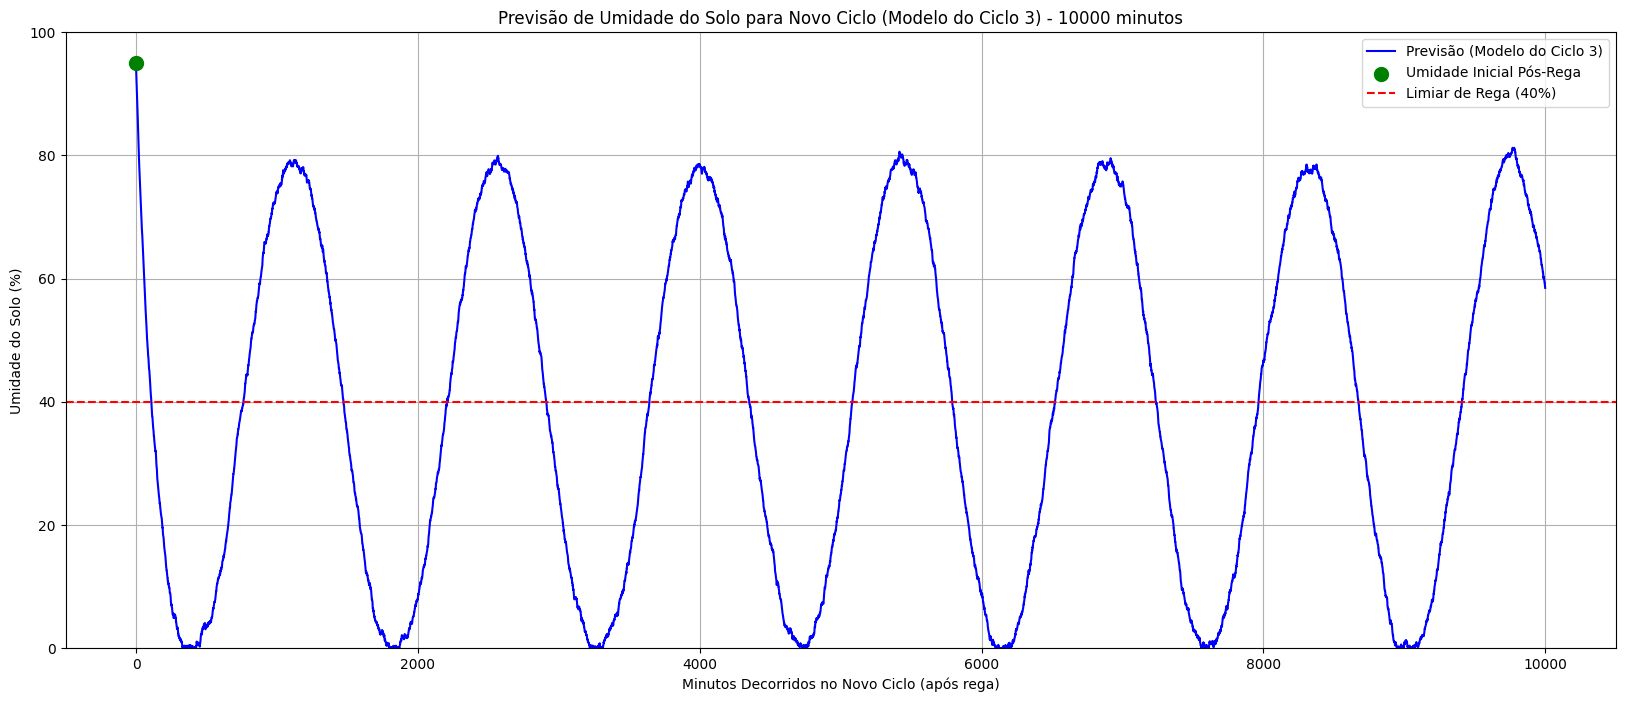

In [28]:
print("\n Exemplo de Previsão para um Novo Ciclo (Usando apenas o Modelo do Ciclo 3) ")

prediction_minutes = 10000 # prever para os próximos 10.000 minutos/pontos de dados

if 3 in ciclo_models:
    model_cycle3 = ciclo_models[3]
    print(f"Usando APENAS o modelo do Ciclo 3 para a previsão para {prediction_minutes} minutos.")

    time_points_future = np.arange(prediction_minutes)
    
    future_temp = 25 + 5 * np.sin(time_points_future / (1440 / (2 * np.pi))) + np.random.randn(prediction_minutes) * 1.5
    future_air_humidity = 60 - 10 * np.cos(time_points_future / (1440 / (2 * np.pi))) + np.random.randn(prediction_minutes) * 2.5

    future_exog_data = pd.DataFrame({
        'Temperatura': future_temp,
        'Umidade_do_Ar': future_air_humidity
    })
    future_exog_data.index = time_points_future
    
    initial_new_cycle_moisture = 95.0 

    predicted_moisture_path_c3 = [initial_new_cycle_moisture]
    params_c3 = model_cycle3.params
    const_c3 = params_c3.get('const', 0)
    phi1_c3 = params_c3['Umidade_do_Solo.L1']
    beta_temp_c3 = params_c3['Temperatura']
    beta_air_hum_c3 = params_c3['Umidade_do_Ar']

    for i in range(len(future_exog_data)):
        y_prev = predicted_moisture_path_c3[-1]
        temp_t = future_exog_data['Temperatura'].iloc[i]
        air_hum_t = future_exog_data['Umidade_do_Ar'].iloc[i]
        predicted_y_t = const_c3 + phi1_c3 * y_prev + beta_temp_c3 * temp_t + beta_air_hum_c3 * air_hum_t
        predicted_y_t = max(0, min(100, predicted_y_t)) 
        predicted_moisture_path_c3.append(predicted_y_t)
    
    forecasted_moisture_single_model = pd.Series(predicted_moisture_path_c3[1:], index=future_exog_data.index)

    print(f"\nPrevisão de umidade do solo para {prediction_minutes} minutos futuros (Usando APENAS o Modelo do Ciclo 3):")
    print(forecasted_moisture_single_model)

    plt.figure(figsize=(20, 8)) 
    
    forecast_x_axis = np.arange(len(forecasted_moisture_single_model)) 
    
    plt.plot(forecast_x_axis, forecasted_moisture_single_model, label='Previsão (Modelo do Ciclo 3)', linestyle='-', color='blue')
    plt.scatter(forecast_x_axis[0], initial_new_cycle_moisture, color='green', s=100, zorder=5, label='Umidade Inicial Pós-Rega')
    
    reg_threshold = 40
    plt.axhline(y=reg_threshold, color='red', linestyle='--', label=f'Limiar de Rega ({reg_threshold}%)')

    plt.title(f'Previsão de Umidade do Solo para Novo Ciclo (Modelo do Ciclo 3) - {prediction_minutes} minutos')
    plt.xlabel('Minutos Decorridos no Novo Ciclo (após rega)')
    plt.ylabel('Umidade do Solo (%)')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 100)
    plt.show()

else:
    print("O modelo do Ciclo 3 não foi treinado com sucesso. Não foi possível gerar a previsão.")


In [29]:
desvios = df.groupby("ID_Ciclo")["Umidade_do_Solo"].std()

# printar o desvio de cada ciclo
for ciclo, desvio in desvios.items():
    print(f"Ciclo {ciclo}: desvio padrão = {desvio:.2f}")

# calcular média dos desvios
media_dos_desvios = desvios.mean()
print(f"\nMédia dos desvios padrão: {media_dos_desvios:.2f}")


Ciclo 0: desvio padrão = 9.31
Ciclo 1: desvio padrão = 7.77
Ciclo 2: desvio padrão = 5.68
Ciclo 3: desvio padrão = 14.56
Ciclo 4: desvio padrão = 5.85

Média dos desvios padrão: 8.64



Primeiras previsões de umidade:
0    94.201757
1    93.585956
2    92.681522
3    91.828783
4    91.245968
dtype: float64

Últimas previsões de umidade:
9995    59.257247
9996    59.266610
9997    58.840088
9998    58.648516
9999    58.490854
dtype: float64

Primeiras incertezas propagadas:
0    8.824759
1    9.005600
2    9.178484
3    9.343958
4    9.502515
dtype: float64

Últimas incertezas propagadas:
9995    14.374728
9996    14.374728
9997    14.374728
9998    14.374728
9999    14.374728
dtype: float64


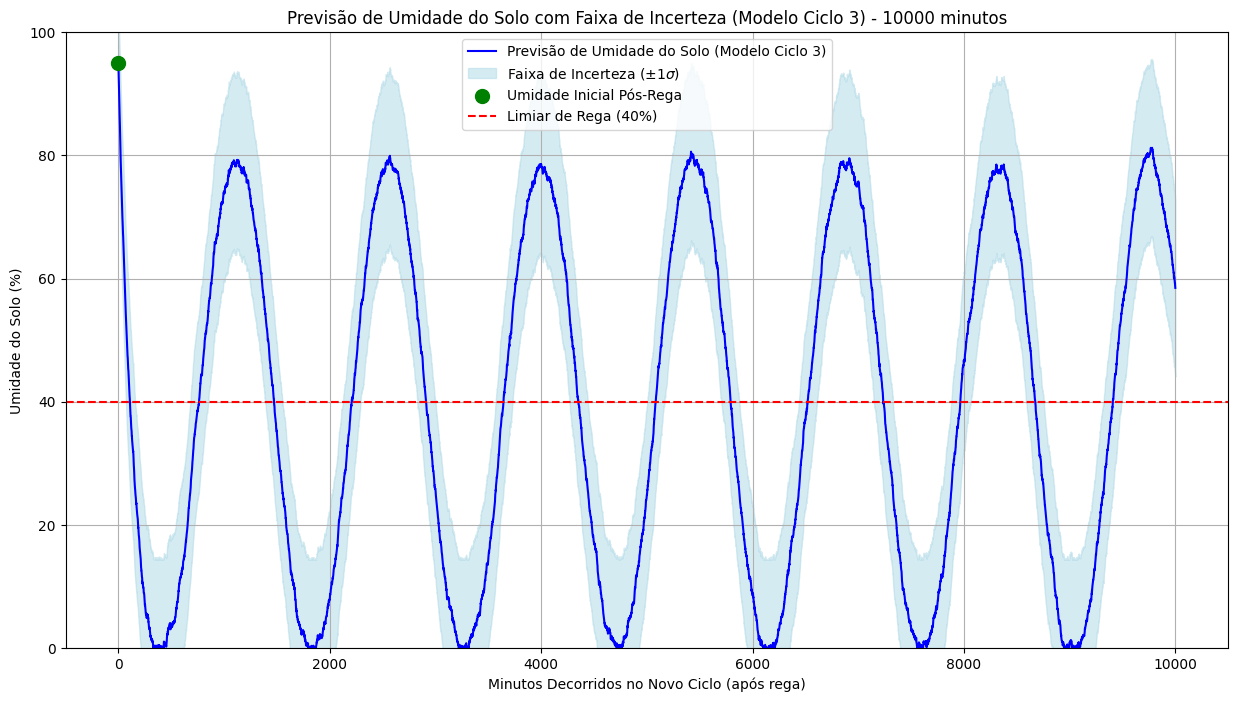

In [30]:
# parâmetros do Modelo do Ciclo 3 (obtidos do treinamento)
const_c3 = 2.602129
phi1_c3 = 0.987399
beta_temp_c3 = -0.105116
beta_air_hum_c3 = 0.008624

# parâmetros de Erro dos Sensores
sigma_temp_sensor = 0.5 
sigma_air_hum_sensor = 3.5 
sigma_initial_moisture = media_dos_desvios

sigma_epsilon_model = 2.274 

# configurações da Simulação de Previsão 
prediction_minutes = 10000 
initial_new_cycle_moisture = 95.0 

# gerando Dados exógenos futuros
time_points_future = np.arange(prediction_minutes)
future_temp = np.full(prediction_minutes, 30.0) + np.random.randn(prediction_minutes) * 0.5 
future_air_humidity = np.full(prediction_minutes, 40.0) + np.random.randn(prediction_minutes) * 1.0 

# listas para armazenar os resultados da previsão e da incerteza
predicted_moisture_path = [initial_new_cycle_moisture] 
propagated_uncertainty_path = [sigma_initial_moisture] 


for i in range(prediction_minutes):
   
    y_prev = predicted_moisture_path[-1] 
    sigma_y_prev = propagated_uncertainty_path[-1] 
    
    # obter valores das variáveis exógenas para o minuto atual
    temp_t = future_exog_data['Temperatura'].iloc[i] 
    air_hum_t = future_exog_data['Umidade_do_Ar'].iloc[i]
    
    # cálculo da proxima umidade
    # U_t = const + phi1 * U_t-1 + beta_temp * T_t + beta_air_hum * UA_t
    predicted_y_t = const_c3 + phi1_c3 * y_prev + beta_temp_c3 * temp_t + beta_air_hum_c3 * air_hum_t
    
   
    predicted_y_t = max(0, min(100, predicted_y_t)) 
    predicted_moisture_path.append(predicted_y_t) 
    
    # cálculo da incerteza propagada para o minuto atual (sigma_U_t)
    variance_Ut = (phi1_c3**2 * sigma_y_prev**2) + \
                  (beta_temp_c3**2 * sigma_temp_sensor**2) + \
                  (beta_air_hum_c3**2 * sigma_air_hum_sensor**2) + \
                  (sigma_epsilon_model**2)
    
    sigma_Ut = np.sqrt(variance_Ut) 
    propagated_uncertainty_path.append(sigma_Ut) 


forecasted_moisture = pd.Series(predicted_moisture_path[1:], index=time_points_future)
forecasted_uncertainty = pd.Series(propagated_uncertainty_path[1:], index=time_points_future)

print(f"\nPrimeiras previsões de umidade:")
print(forecasted_moisture.head())
print("\nÚltimas previsões de umidade:")
print(forecasted_moisture.tail())

print(f"\nPrimeiras incertezas propagadas:")
print(forecasted_uncertainty.head())
print("\nÚltimas incertezas propagadas:")
print(forecasted_uncertainty.tail())

# plotagem
plt.figure(figsize=(15, 8)) 
plt.plot(forecasted_moisture.index, forecasted_moisture, label='Previsão de Umidade do Solo (Modelo Ciclo 3)', color='blue')

# plotar a faixa de incerteza +/- 1 desvio padrão
plt.fill_between(forecasted_moisture.index, 
                 (forecasted_moisture - forecasted_uncertainty).clip(0, 100), 
                 (forecasted_moisture + forecasted_uncertainty).clip(0, 100), 
                 color='lightblue', alpha=0.5, label='Faixa de Incerteza ($\pm 1 \sigma$)')

# marcadores para o início da previsão e o limiar de rega
plt.scatter(forecasted_moisture.index[0], initial_new_cycle_moisture, color='green', s=100, zorder=5, label='Umidade Inicial Pós-Rega')
reg_threshold = 40
plt.axhline(y=reg_threshold, color='red', linestyle='--', label=f'Limiar de Rega ({reg_threshold}%)')

plt.title(f'Previsão de Umidade do Solo com Faixa de Incerteza (Modelo Ciclo 3) - {prediction_minutes} minutos')
plt.xlabel('Minutos Decorridos no Novo Ciclo (após rega)')
plt.ylabel('Umidade do Solo (%)')
plt.legend()
plt.grid(True)
plt.ylim(0, 100) 
plt.show()